In [1]:
#import libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr
import h5py
import scipy.io
from scipy.stats import zscore
import matplotlib.pyplot as plt
from itertools import product

In [2]:
# Load the RNA data from the gzip-compressed CSV file
file_path = '/home/dwk681/workspace/GSE141252_Stoeger_et_al._2022/data/GSE141252_raw_counts.csv.gz'
rna_data = pd.read_csv(file_path, compression='gzip')

# Extract gene names
genes = rna_data['gene_ensembl']

# Assuming the first column is 'gene_ensembl', and the rest are samples
sample_columns = rna_data.columns[1:]

# Initialize a dictionary to hold the b_ij matrix for each tissue
fold_change_matrices = {}

# Define the age groups to compute fold changes for
age_groups = ['09M', '12M', '18M', '24M']  # All age-groupd except for 04M, which is the baseline
tissues = ['Adrenal', 'BAT', 'Blood', 'Brain', 'Cerebellum', 'Esophagus', 'GutEP', 'Heart', 'Kidney', 'LI', 'Liver', 'Lung', 'MuscSat', 'SI', 'Skin', 'Stomach', 'WAT']

# Initialize a dictionary to hold the fold change dataframes for each tissue
fold_changes_dfs = {}

# Calculate the fold changes for each tissue and age
for tissue in tissues:
    # Calculate total signal for the 4-month baseline for this tissue
    baseline_columns = [col for col in rna_data.columns if tissue in col and '04M' in col]
    baseline_avg = rna_data[baseline_columns].mean(axis=1)
    total_baseline_avg = baseline_avg.sum()
    # Calculate the percentage of each entry
    baseline_percentage = (baseline_avg / total_baseline_avg) * 10000
    
    # Initialize a DataFrame to store fold changes for this tissue
    fold_changes = pd.DataFrame(index=genes, columns=age_groups)
    
    for age in age_groups:
        # Calculate total signal for this age group for this tissue
        age_columns = [col for col in rna_data.columns if tissue in col and age in col]
        age_avg = rna_data[age_columns].mean(axis=1)
        total_age_avg = age_avg.sum()
        # Calculate the percentage of each entry
        age_percentage = (age_avg / total_age_avg) * 10000
        
        # Calculate log2 fold change and store in the DataFrame
        fold_changes.loc[:, age] = np.log2(  (age_percentage / (baseline_percentage + 1e-6))   + 1e-6  )  # Adding a small constant to avoid log(0)

    # Store the fold change DataFrame for this tissue
    fold_changes_dfs[tissue] = fold_changes

# make the data frame into a tensor
# The number of genes and age groups are constant, but the number of tissues varies
num_genes = len(genes)
num_ages = len(age_groups)
num_tissues = len(tissues)

# Initialize a 3D numpy array (tensor) with zeros
fold_change_tensor = np.zeros((num_tissues, num_genes, num_ages))

# Populate the tensor with the fold change values
for t_idx, tissue in enumerate(tissues):
    for a_idx, age in enumerate(age_groups):
        # Select the fold change values for the current tissue and age group
        fold_change_values = fold_changes_dfs[tissue][age].values
        # Assign the values to the correct slice of the tensor
        fold_change_tensor[t_idx, :, a_idx] = fold_change_values

#print out statistics for tensor to make sure everything looks ok  
zero_count = np.sum(fold_change_tensor == 0)  
print("Number of zeros before shifting in the tensor is:", zero_count)
min_value = fold_change_tensor.min()
if min_value < 0:
    fold_change_tensor += abs(min_value)
new_min_value = fold_change_tensor.min()    
nan_count = np.sum(np.isnan(fold_change_tensor))    
zero_count = np.sum(fold_change_tensor == 0)    
inf_count = np.sum(np.isinf(fold_change_tensor))
print("The original minimum value in the tensor is:", min_value)
print("The new minimum value in the tensor is:", new_min_value)
print("Number of NaNs in the tensor is:", nan_count)
print("Number of zeros in the tensor is:", zero_count)
print("Number of infinities in the tensor is:", inf_count)    

#take the zscore with respect to age and then print out statistics to make sure evyerhting looks ok
zscored_tensor = zscore(fold_change_tensor, axis=2)
zscored_tensor = np.nan_to_num(zscored_tensor)
min_value = zscored_tensor.min()
if min_value < 0:
    zscored_tensor += abs(min_value)
new_min_value = zscored_tensor.min()
nan_count = np.sum(np.isnan(zscored_tensor))
zero_count = np.sum(zscored_tensor == 0)
inf_count = np.sum(np.isinf(zscored_tensor))
print("The original minimum value in the zscore tensor is:", min_value)
print("The new minimum value in the zscore tensor is:", new_min_value)
print("Number of NaNs in the z-scores:", nan_count)
print("Number of zeros in the z-scores:", zero_count)
print("Number of positive infinities in the z-scores:", inf_count)





Number of zeros before shifting in the tensor is: 0
The original minimum value in the tensor is: -19.931568569324174
The new minimum value in the tensor is: 0.0
Number of NaNs in the tensor is: 0
Number of zeros in the tensor is: 1622306
Number of infinities in the tensor is: 0
The original minimum value in the zscore tensor is: -1.7320507103846263
The new minimum value in the zscore tensor is: 0.0
Number of NaNs in the z-scores: 0
Number of zeros in the z-scores: 1
Number of positive infinities in the z-scores: 0


In [5]:
#tissues = ['Adrenal', 'BAT', 'Blood', 'Brain', 'Cerebellum', 'Esophagus', 'GutEP', 'Heart', 'Kidney', 'LI', 'Liver', 'Lung', 'MuscSat', 'SI', 'Skin', 'Stomach', 'WAT']
#fold_changes_dfs['BAT']
#zscored_tensor_non_negative.shape

h5_file_path = '/home/dwk681/workspace/GSE141252_Stoeger_et_al._2022/tensor_data/RNA_tensor.h5'

with h5py.File(h5_file_path, 'w') as h5_file:
    # Create datasets for each tensor
    h5_file.create_dataset('fold_change_tensor', data=fold_change_tensor)
    h5_file.create_dataset('zscored_tensor', data=zscored_tensor)


In [ ]:
# Load the MATLAB results
file_path = '/home/dwk681/workspace/GSE141252_Stoeger_et_al._2022/fold_change_tensor_non_negative_results.mat'
data = scipy.io.loadmat(file_path)

# Extract the sol_factors
sol_factors = data['sol_factors']

# Analyze the results
# Example: Print the shapes of the factors
for i in range(sol_factors.shape[1]):
    u, v, p = sol_factors[0, i]
    print(f"Rank {i+1}: U shape = {u.shape}, V shape = {v.shape}, P shape = {p.shape}")




In [18]:
# Repeat the above step but first filter out all genes that are not being expressed at all
# Initialize a dictionary to hold the expression dataframes for each tissue
expression_dfs = {}

# Calculate and store expression data for each tissue and age group
for tissue in tissues:
    tissue_expression = pd.DataFrame(index=genes, columns=age_groups)
    for age in age_groups:
        # Calculate total signal for this age group for this tissue
        age_columns = [col for col in rna_data.columns if tissue in col and age in col]
        age_avg = rna_data[age_columns].mean(axis=1)
        tissue_expression[age] = age_avg
    expression_dfs[tissue] = tissue_expression.copy()  # Use .copy() to ensure each tissue has its own DataFrame

    
# Initialize a mask with all True values
non_zero_genes_mask = pd.Series(True, index=expression_dfs[tissues[0]].index)

# Update the mask to be False for genes with zero expression in any tissue at any age
for tissue in tissues:
    non_zero_genes_mask &= (expression_dfs[tissue] != 0).any(axis=1)

# Filter the expression dataframes
expression_dfs_filtered = {tissue: df[non_zero_genes_mask] for tissue, df in expression_dfs.items()}

# Update the genes list
genes_filtered = non_zero_genes_mask[non_zero_genes_mask].index.tolist()

# Displaying the first few rows of the filtered DataFrame for a sample tissue and the updated genes list
(expression_dfs_filtered[tissues[0]].head(), genes_filtered[:5])



(                    09M  12M  18M  24M
 gene_ensembl                          
 ENSMUSG00000000001  NaN  NaN  NaN  NaN
 ENSMUSG00000000003  NaN  NaN  NaN  NaN
 ENSMUSG00000000028  NaN  NaN  NaN  NaN
 ENSMUSG00000000031  NaN  NaN  NaN  NaN
 ENSMUSG00000000037  NaN  NaN  NaN  NaN,
 ['ENSMUSG00000000001',
  'ENSMUSG00000000003',
  'ENSMUSG00000000028',
  'ENSMUSG00000000031',
  'ENSMUSG00000000037'])

In [128]:
#Uncommnet if you want to make sure there are no NANs in the data frame
''' 
for tissue in tissues:
    for age in age_groups:
        nan_exists = fold_change_dfs[tissue][age].isna().any()
        print(f"Are there NaN values in the fold change data for {tissue} at {age}? {nan_exists}")
'''

' \nfor tissue in tissues:\n    for age in age_groups:\n        nan_exists = fold_change_dfs[tissue][age].isna().any()\n        print(f"Are there NaN values in the fold change data for {tissue} at {age}? {nan_exists}")\n'

In [133]:
# Assuming you know the number of genes. Replace this with the actual number.
num_genes = len(genes)  # Example number, replace with the actual number of genes

# Define the number of features you want to simulate
num_features = 200  # Example number of features

# Set a seed for reproducibility
np.random.seed(0)

features_matrix = pd.DataFrame(np.random.rand(num_genes, num_features), index=genes)

# Display the first few rows of the simulated features_matrix
print(features_matrix.head())

                         0         1         2         3         4    \
gene_ensembl                                                           
ENSMUSG00000000001  0.548814  0.715189  0.602763  0.544883  0.423655   
ENSMUSG00000000003  0.311796  0.696343  0.377752  0.179604  0.024679   
ENSMUSG00000000028  0.401260  0.929291  0.099615  0.945302  0.869489   
ENSMUSG00000000031  0.174658  0.327988  0.680349  0.063208  0.607249   
ENSMUSG00000000037  0.039993  0.639705  0.408303  0.377407  0.809365   

                         5         6         7         8         9    ...  \
gene_ensembl                                                          ...   
ENSMUSG00000000001  0.645894  0.437587  0.891773  0.963663  0.383442  ...   
ENSMUSG00000000003  0.067250  0.679393  0.453697  0.536579  0.896671  ...   
ENSMUSG00000000028  0.454162  0.326701  0.232744  0.614465  0.033075  ...   
ENSMUSG00000000031  0.477647  0.284000  0.238413  0.514513  0.367928  ...   
ENSMUSG00000000037  0.709035  0.9

In [134]:
# Initialize dictionaries to store models, median ranks, and evaluation metrics
models_dict = {}
median_ranks_dict = {}
evaluation_dict = {}

for tissue in tissues:
    for age in age_groups:
        num_models = 10
        tissue_age_models = []
        median_ranks = []
        correlations = []  # Initialize correlations list

        for i in range(num_models):
            # Ensure that the target vector (fold change values) aligns with the features_matrix
            y = fold_change_dfs[tissue][age].reindex(features_matrix.index)

            # Split the data into train and test sets
            X_train, X_test, y_train, y_test = train_test_split(features_matrix, y, test_size=0.1, random_state=i)

            # Create and train the gradient-boosting model
            model = GradientBoostingRegressor(random_state=i)
            model.fit(X_train.dropna(), y_train.dropna())  # Ensure no NaN values

            # Store the model
            tissue_age_models.append(model)

            # Calculate and store feature importances and median rank
            feature_importances = model.feature_importances_
            ranked_features = np.argsort(feature_importances)[::-1]  # Rank features by importance
            median_rank = np.median(ranked_features)
            median_ranks.append(median_rank)

            # Evaluate the model on the test set
            y_pred = model.predict(X_test)
            correlation, _ = spearmanr(y_test, y_pred)
            correlations.append(correlation)

        # Store the models, median ranks, and median correlations for this tissue-age group
        models_dict[(tissue, age)] = tissue_age_models
        median_ranks_dict[(tissue, age)] = np.median(median_ranks)
        evaluation_dict[(tissue, age)] = np.median(correlations)




KeyboardInterrupt: 

In [132]:
features_matrix

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
Gene_0,0.548814,0.715189,0.602763,0.544883,0.423655,0.645894,0.437587,0.891773,0.963663,0.383442,...,0.398221,0.209844,0.186193,0.944372,0.739551,0.490459,0.227415,0.254356,0.058029,0.434417
Gene_1,0.311796,0.696343,0.377752,0.179604,0.024679,0.067250,0.679393,0.453697,0.536579,0.896671,...,0.062713,0.424032,0.258684,0.849038,0.033305,0.958983,0.355369,0.356707,0.016329,0.185232
Gene_2,0.401260,0.929291,0.099615,0.945302,0.869489,0.454162,0.326701,0.232744,0.614465,0.033075,...,0.739884,0.898062,0.672582,0.528940,0.304446,0.997962,0.362189,0.470649,0.378245,0.979527
Gene_3,0.174658,0.327988,0.680349,0.063208,0.607249,0.477647,0.284000,0.238413,0.514513,0.367928,...,0.568218,0.246557,0.596433,0.117526,0.975884,0.932561,0.391797,0.242179,0.250398,0.483394
Gene_4,0.039993,0.639705,0.408303,0.377407,0.809365,0.709035,0.954334,0.351936,0.897543,0.769967,...,0.012171,0.322830,0.229567,0.506863,0.736853,0.097676,0.514922,0.938412,0.228647,0.677141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Gene_43425,0.002580,0.313539,0.058766,0.499187,0.808221,0.138732,0.301711,0.577402,0.157363,0.523020,...,0.211563,0.824925,0.388509,0.205365,0.611693,0.375046,0.183240,0.967246,0.087562,0.069967
Gene_43426,0.543741,0.951535,0.600908,0.910568,0.998656,0.098114,0.383854,0.286133,0.111796,0.869804,...,0.969875,0.148484,0.963825,0.452016,0.216094,0.799398,0.056839,0.895741,0.657543,0.814228
Gene_43427,0.638730,0.528217,0.284441,0.994471,0.296285,0.881466,0.497050,0.738617,0.565598,0.956137,...,0.132096,0.914367,0.025866,0.659436,0.353251,0.868699,0.194066,0.458481,0.392778,0.263316
Gene_43428,0.087231,0.090555,0.344656,0.593301,0.958200,0.172662,0.580123,0.358753,0.348730,0.880162,...,0.072910,0.099553,0.707749,0.686611,0.676574,0.645875,0.174200,0.275626,0.800352,0.415574


In [34]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import numpy as np

# Load the RNA data from the gzip-compressed CSV file
file_path = '/home/dwk681/workspace/GSE141252_Stoeger_et_al._2022/GSE141252_raw_counts.csv.gz'
rna_data = pd.read_csv(file_path, compression='gzip')

# Extract gene names
genes = rna_data['gene_ensembl']

# Assuming the first column is 'gene_ensembl', and the rest are samples
sample_columns = rna_data.columns[1:]

# Calculate log2-transformed fold changes for each sample relative to 4-month-old mice
# Assuming columns are named in the form 'Tissue_Age_Sample', e.g., 'Adrenal_24M_F0_1'
fold_change_dict = {}
for column in sample_columns:
    _, tissue, age, _, _ = column.split('_')
    if age != '4M':  # Skip the 4-month-old baseline
        # Find the corresponding 4-month-old baseline columns for the same tissue
        baseline_columns = [col for col in sample_columns if tissue in col and '4M' in col]
        baseline_expression = rna_data[baseline_columns].mean(axis=1) + 1  # Add 1 to avoid log(0)
        fold_change = np.log2((rna_data[column] + 1) / baseline_expression)  # Log2 fold change
        fold_change_dict[column] = fold_change

# Convert the fold change dictionary to a DataFrame
fold_change_df = pd.DataFrame(fold_change_dict)


# Once we have all median ranks, we can reshape the DataFrame to match the desired output
# The final DataFrame should have tissues as rows and age groups as columns
# This code will need to be adjusted based on the actual data and desired output format


gene_ensembl,ENSMUSG00000071633,ENSMUSG00000039234,ENSMUSG00000076710,ENSMUSG00000095554,ENSMUSG00000071303,ENSMUSG00000050505,ENSMUSG00000026393,ENSMUSG00000084331,ENSMUSG00000101847,ENSMUSG00000011958,...,ENSMUSG00000032623,ENSMUSG00000100088,ENSMUSG00000085197,ENSMUSG00000041700,ENSMUSG00000102394,ENSMUSG00000094822,ENSMUSG00000038537,ENSMUSG00000032392,ENSMUSG00000022032,ENSMUSG00000034164
M01_Adrenal_24M_F0_1,-6.274507,-0.356970,-0.026842,0.0,-0.712374,-4.081074,0.159494,0.0,0.0,0.830466,...,-0.399717,0.0,-0.315139,-3.063762,-0.026842,0.0,-0.399717,1.497945,0.143703,-2.422385
M01_BAT_24M_F0_1,-6.274507,-3.007735,-0.026842,0.0,-0.712374,-4.081074,0.168043,0.0,0.0,0.133187,...,-0.399717,0.0,-0.315139,-3.063762,-0.026842,0.0,-0.399717,-0.411081,-1.032795,-1.574388
M01_Blood_24M_F0_1,-6.274507,-7.651591,-0.026842,0.0,-0.712374,-4.081074,-6.913041,0.0,0.0,-5.532939,...,-0.399717,0.0,-0.315139,-3.063762,-0.026842,0.0,-0.399717,-5.902934,-7.222619,-2.422385
M01_Brain_24M_F0_1,-6.274507,-7.651591,-0.026842,0.0,-0.712374,-4.081074,-9.234969,0.0,0.0,-8.702864,...,-0.399717,0.0,-0.315139,-3.063762,-0.026842,0.0,-0.399717,-5.902934,-7.222619,-4.744313
M01_Esophagus_24M_F0_1,-6.274507,-0.394203,-0.026842,0.0,-0.712374,-4.081074,0.258886,0.0,0.0,0.556880,...,-0.399717,0.0,-0.315139,2.428091,-0.026842,0.0,-0.399717,-0.545382,1.613431,-1.574388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
M36_Lung_24M_F150_2,-6.274507,-1.112432,-0.026842,0.0,-0.712374,-4.081074,-0.838364,0.0,0.0,-0.272411,...,-0.399717,0.0,-0.315139,-3.063762,-0.026842,0.0,-0.399717,-2.733009,-2.830302,0.300081
M37_Lung_24M_F150_3,-6.274507,-0.553559,-0.026842,0.0,-0.712374,-4.081074,-1.100543,0.0,0.0,-0.191111,...,-0.399717,0.0,-0.315139,-3.063762,-0.026842,0.0,-0.399717,-2.202494,-2.578763,-0.656850
M50_Lung_24M_F150_4,-6.274507,-0.596308,-0.026842,0.0,-0.712374,-1.759146,-0.691937,0.0,0.0,0.288658,...,-0.399717,0.0,-0.315139,-3.063762,-0.026842,0.0,-0.399717,-2.202494,-1.865067,-0.351995
M51_Lung_24M_F150_5,-6.274507,-0.937345,-0.026842,0.0,-0.712374,-4.081074,-1.142212,0.0,0.0,-0.099237,...,-0.399717,0.0,-0.315139,-3.063762,-0.026842,0.0,-0.399717,-3.581006,-2.013166,-0.100457


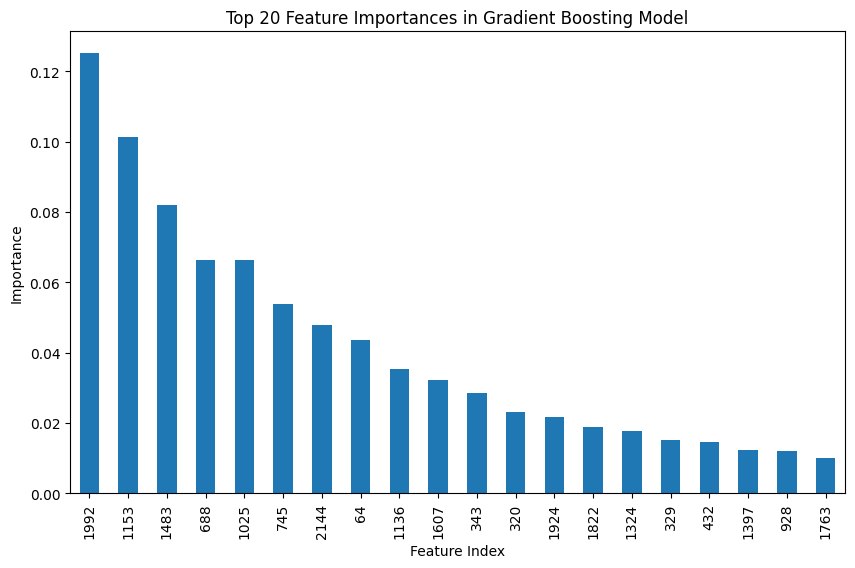

Spearman Correlation: nan


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr

# Number of samples and features in the synthetic dataset
n_samples = 10
n_features = 2236

# Generate synthetic data
np.random.seed(42)
X = np.random.rand(n_samples, n_features)  # Feature matrix
y = np.random.rand(n_samples)  # Target vector

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Initialize and train the Gradient Boosting Regressor
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Extract feature importance
feature_importance = model.feature_importances_

# Create a pandas Series for easier plotting
feature_importance_series = pd.Series(feature_importance, index=range(n_features))

# Sort the features by importance
sorted_feature_importance = feature_importance_series.sort_values(ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sorted_feature_importance[:20].plot(kind='bar')  # Plotting top 20 features for visibility
plt.title('Top 20 Feature Importances in Gradient Boosting Model')
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.show()

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model using Spearman correlation
spearman_corr, _ = spearmanr(y_test, y_pred)
print(f"Spearman Correlation: {spearman_corr}")



In [2]:
feature_importance

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       0.00000000e+00, 3.08331492e-07, 0.00000000e+00])

In [3]:
from sklearn.inspection import plot_partial_dependence

fig, ax = plt.subplots(figsize=(12, 8))
plot_partial_dependence(model, X_train, features=[0, 1, 2], ax=ax) # Replace 0, 1, 2 with indices of features of interest
plt.show()


ImportError: cannot import name 'plot_partial_dependence' from 'sklearn.inspection' (/home/dwk681/.conda/envs/scRNAseq/lib/python3.8/site-packages/sklearn/inspection/__init__.py)

In [137]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np

# Example of how to create a combined dataset
combined_features = []
combined_targets = []
combined_tissue_age_labels = []

for tissue in tissues:
    for age in age_groups:
        # Extract features and target for each tissue-age pair
        features = features_matrix  # Assume features_matrix is the same for all
        target = fold_change_dfs[tissue][age]

        # Create tissue-age labels (one-hot encoded or similar)
        tissue_age_label = f"{tissue}_{age}"  # Example label format

        combined_features.append(features)
        combined_targets.append(target)
        combined_tissue_age_labels.extend([tissue_age_label] * len(target))

# Convert to DataFrame or suitable format for training
combined_features_df = pd.concat(combined_features)
combined_targets_series = pd.concat(combined_targets)
combined_labels_series = pd.Series(combined_tissue_age_labels)

# One-hot encode the tissue-age labels
encoder = OneHotEncoder()
encoded_labels = encoder.fit_transform(combined_labels_series.values.reshape(-1, 1)).toarray()

# Use the appropriate method to get feature names based on scikit-learn version
try:
    # For scikit-learn version 0.22 and later
    encoded_labels_columns = encoder.get_feature_names_out()
except AttributeError:
    # For scikit-learn versions before 0.22
    encoded_labels_columns = encoder.get_feature_names()

# Add encoded labels to the features DataFrame
encoded_labels_df = pd.DataFrame(encoded_labels, columns=encoded_labels_columns)
combined_features_df = pd.concat([combined_features_df.reset_index(drop=True), encoded_labels_df], axis=1)


In [138]:
combined_features_df

,0,1,2,3,4,5,6,7,8,9,...,x0_Skin_18M,x0_Skin_24M,x0_Stomach_09M,x0_Stomach_12M,x0_Stomach_18M,x0_Stomach_24M,x0_WAT_09M,x0_WAT_12M,x0_WAT_18M,x0_WAT_24M
0,0.548814,0.715189,0.602763,0.544883,0.423655,0.645894,0.437587,0.891773,0.963663,0.383442,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.311796,0.696343,0.377752,0.179604,0.024679,0.067250,0.679393,0.453697,0.536579,0.896671,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.401260,0.929291,0.099615,0.945302,0.869489,0.454162,0.326701,0.232744,0.614465,0.033075,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.174658,0.327988,0.680349,0.063208,0.607249,0.477647,0.284000,0.238413,0.514513,0.367928,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.039993,0.639705,0.408303,0.377407,0.809365,0.709035,0.954334,0.351936,0.897543,0.769967,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2953235,0.002580,0.313539,0.058766,0.499187,0.808221,0.138732,0.301711,0.577402,0.157363,0.523020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2953236,0.543741,0.951535,0.600908,0.910568,0.998656,0.098114,0.383854,0.286133,0.111796,0.869804,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2953237,0.638730,0.528217,0.284441,0.994471,0.296285,0.881466,0.497050,0.738617,0.565598,0.956137,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2953238,0.087231,0.090555,0.344656,0.593301,0.958200,0.172662,0.580123,0.358753,0.348730,0.880162,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define a simple CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(tensor_height, tensor_width, tensor_channels)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1)  # or more neurons in the last layer depending on your specific task
])

model.compile(optimizer='adam', loss='mean_squared_error')  # Define optimizer and loss function

# Train the model
model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))


In [24]:
# Function to create a dataframe with specified number of emails and features, filled with random numbers
def create_dataframe(num_emails, num_features):
    column_labels = [f'Feature {i+1}' for i in range(num_features)]
    row_labels = [f'Bin {i+1}' for i in range(num_emails)]
    data = np.random.rand(num_emails, num_features)
    return pd.DataFrame(data, index=row_labels, columns=column_labels)

# Example usage of the function
num_emails = 15  # Number of emails
num_features = 5  # Number of features
dataframe = create_dataframe(num_emails, num_features)


values = np.random.randint(1, 11, size=num_emails)
# Adding a new column named 'Prediction' with random choices between 'Real' and 'Spam'
dataframe['Hypermatrix Factor 4'] = values

dataframe


,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Hypermatrix Factor 4
Bin 1,0.148185,0.202317,0.552431,0.352808,0.262560,8
Bin 2,0.440417,0.677599,0.836292,0.766274,0.589942,5
Bin 3,0.213192,0.669842,0.555024,0.287198,0.257054,1
Bin 4,0.056439,0.028592,0.673903,0.097296,0.053679,10
Bin 5,0.523527,0.761064,0.398477,0.001722,0.162360,5
Bin 6,0.257404,0.035385,0.594281,0.891553,0.126924,5
Bin 7,0.950649,0.791795,0.326750,0.353456,0.271203,2
Bin 8,0.509387,0.171507,0.322688,0.401170,0.405266,8
Bin 9,0.655325,0.280910,0.221015,0.222105,0.875663,4
Bin 10,0.093985,0.665979,0.378905,0.310335,0.833544,8


In [21]:
# Creating a new DataFrame with features as rows and a single column for rankings
num_features = 5  # Number of features
feature_labels = [f'Feature {i+1}' for i in range(num_features)]
rankings = [1, 2, 3, 2, 3]

# Creating the DataFrame
feature_rankings_df = pd.DataFrame(rankings, index=feature_labels, columns=['Ranking'])

feature_rankings_df


,Ranking
Feature 1,1
Feature 2,2
Feature 3,3
Feature 4,2
Feature 5,3
